# Computational Finance

## Lab Assignment 1

Authors:
- Kevin de Vries
- Jed Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 00000000
- 11391952

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm

# Part 1: Option valuation

In [4]:
def payoff(S,K,call):
    '''
    Calculates the payoff of an option layer
    '''
    
    f = S - K if call else K - S
    f[f < 0] = 0
    return f

def option_valuation(S0,K,M,T,r,v,call=True,american=False):
    '''
    Calculates the option valuation from a given node.
    Maturity is set to a period of one year.
    
    Parameters
        S0: float
            Current stock price
        K: float
            Strike price
        M: float
            Maturity of the option
        T: int
            Number of time steps
        r: float
            Interest rate
        v: float
            Volatility
        call: Bool
            Determines if option is a call or a put
        american: Bool
            Determines if option is American of European
        
    Returns
        f: float
            Option valuation
        delta: float
            Hedge parameter
    '''
    
    # Time step length
    dt = M / T
    
    # Calculate tree parameters
    u = np.exp(v * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at expiration
    S = S0 * u**(np.arange(0,T+1) - np.arange(0,T+1)[::-1])
    
    # Call option value at expiration
    f = payoff(S,K,call)
    
    for i in range(T-1):
        f = np.exp(-r*dt) * (p*f[1:T-i+1] + (1-p)*f[0:T-i])
        
        # American option can be exercised before maturity.
        # The highest possible payoff per node is thus considered risk neutral.
        if american:
            S = S0 * u**(np.arange(0,T-i) - np.arange(0,T-i)[::-1])
            f_potential = payoff(S,K,call)
            f = np.maximum(f,f_potential)
            
    delta = (f[1]-f[0]) / (S0*(u-d))
    f = np.exp(-r*dt) * (p*f[1] + (1-p)*f[0])
    
    return f, delta

# Black Scholes formula

def blackScholes(r, K, T, S_0, sigma):
    '''
    Calculates the Hedge ratio, call price and put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        
    Returns
        N1: float
            Hedge ratio
        c: float
            Call price
        p: float
            Put price
    '''
    d1 = (math.log(S_0/K)+(r+(sigma**2)/2)*T)/sigma*(T**0.5)
    d2 = d1-sigma*(T**0.5)
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    c = S_0*N1 - K*math.exp(-r*T)*N2
    p = K*math.exp(-r*T)*N4 - S_0*N3
    return N1, c, p 

In [5]:
# Test option valuation on the example in the slides

f,delta = option_valuation(50,50,5/12,5,0.1,0.4,call=False)
print(f)
print(delta)

4.31901871652
-0.393051801205


In [6]:
# Test option valuation on the initial parameters in the assignment
# Analytical value of valuation was supposedly ~11.4 according to the lecturer

cur, strike = 100.0, 99
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility)

print(f)
print(delta)

11.5464348508
0.672556964605


In [7]:
# Test option valuation on the initial parameters in the assignment using American option

cur, strike = 100.0, 99.0
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility,call=False,american=True)

print(f)
print(delta)

5.34776349842
-0.382039156259


In [8]:
r = 0.06 # interest rate
K = 99 # strike price
T = 1 # time of maturity
S_0 = 100 # current stock price
sigma = 0.2 # volatility

hedgeRatio, callPrice, putPrice =  blackScholes(r, K, T, S_0, sigma) #returns the analytic values 

print("Hedge ratio is %f" % hedgeRatio)
print("Call price is %f" % callPrice)

Hedge ratio is 0.673736
Call price is 11.544280


# Part 2: Hedging Simulations

In [1]:
def stock_price(S_0, N, r = .06, sigma = .2, T = 1):
    delta_t = T / N
    S = np.zeros(N)
    dZ = np.sqrt(delta_t) * np.random.normal(0,1, N)
    S[0] = S_0
    for i in range(1, N):
        S[i] = S[i-1] + r * S[i-1] * delta_t + sigma * S[i-1] * dZ[i]
    return S

def hedge_ratios(S, r = .06, sigma = .2, K = 99, T = 1):
    hedge_ratios = np.zeros(len(S))
    for i in range(len(S)):
        d1 = np.log(S[i]/K) + T * (r + ((sigma**2) /2)) / (sigma * np.sqrt(T))
        hedge_ratios[i] = norm.cdf(d1)
    return hedge_ratios

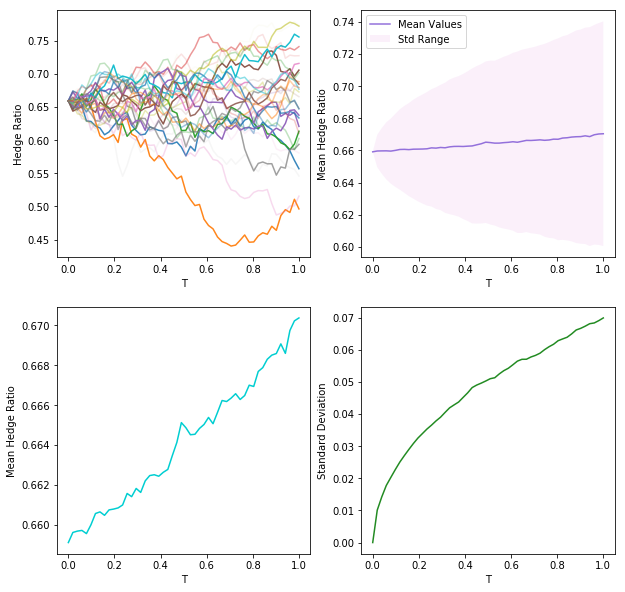

In [4]:
'''
Set parameters.
'''
T = 1
N = 52
r = .06
K = 99
S_0 = 100
stock_price_volatility = .2
option_valuation_volatility = .2
num_simulations = 1000

'''
Run simulations.
'''
# Each row is one simulation of the stock price.
stock_prices = np.zeros((num_simulations, N))

# Each row is one simulation of the hedge parameter. 
deltas = np.zeros((num_simulations, N))

# Run simultations and store results.
for i in range(num_simulations):
    stock_prices[i] = stock_price(S_0, N, r, stock_price_volatility, T)
    deltas[i] = hedge_ratios(stock_prices[i], r, option_valuation_volatility, K, T)

# Compute simulations summay statistics.
mean_values = np.mean(deltas, axis = 0)
std_values = np.std(deltas, axis = 0)

'''
Plot the results.
'''
x_axis = np.linspace(0, 1, N)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.xlabel('T')
plt.ylabel('Hedge Ratio')
for i in range(1, 30):
    plt.plot(x_axis, deltas[i], alpha = 30/i)

plt.subplot(2, 2, 2)
plt.xlabel('T')
plt.ylabel('Mean Hedge Ratio')
plt.plot(x_axis, mean_values, color="mediumpurple", label ='Mean Values')
plt.fill_between(x_axis, mean_values - std_values, mean_values + std_values, facecolor='orchid', alpha=.1, label ='Std Range')
plt.legend(loc='upper left')
plt.subplot(2, 2, 3)
plt.xlabel('T')
plt.ylabel('Mean Hedge Ratio')
plt.plot(x_axis, mean_values, color='darkturquoise')
plt.subplot(2, 2, 4)
plt.xlabel('T')
plt.ylabel('Standard Deviation')
plt.plot(x_axis, std_values, color='forestgreen')
plt.show()